# Using Dgraph to Explore the Offshore Leaks Dataset

## Analyzing the Raw Data

#### [Overview of the Raw Data](https://github.com/dgraph-io/vlg/blob/main/notes/1.%20Raw%20Data%20Analysis.md)

#### Data Normalization and Sanitizing

* [CSVKit to the rescue, an example](https://github.com/dgraph-io/vlg/blob/main/notes/csvstat/entities.txt)
* [1000 Bad Dates](https://github.com/dgraph-io/vlg/blob/ba577e1b65ae4dfa93a002ccd2009fea1113578b/tools/model/date_time.go#L19)
* [Non-null nulls](https://github.com/dgraph-io/vlg/blob/ba577e1b65ae4dfa93a002ccd2009fea1113578b/tools/model/entity.go#LL29C2-L29C2)

#### Storing Clean Data Transiently

* [Use Badger to store temporarily results (aka the export before the import)](https://github.com/dgraph-io/vlg/blob/ba577e1b65ae4dfa93a002ccd2009fea1113578b/tools/preload/main.go#L22)

## Dgraph Schemas Overview

Dgraph supports two types of schemas: DQL and GraphQL.

* DQL is a predicate-first focused schema language that supports some aspects not yet supported by the GraphQL syntax such as multi-lingual predicates and facets (data information stored on edges between nodes)
* GraphQL is a type-first focused schema language that only supports spec-compliant elements such as types, unions, and interfaces

## Building a GraphQL Schema for the Offshore Leaks Dataset

Questions first, schema second, [description](https://github.com/dgraph-io/vlg/blob/main/notes/2.%20Schema%20Design.md#schema-design-1)

* full term, text, trigram search for names, [schema ref](https://github.com/dgraph-io/vlg/blob/ba577e1b65ae4dfa93a002ccd2009fea1113578b/schema/schema.graphql#L28)
* restrict by source (Panama Papers, Paradise Papers), [schema ref](https://github.com/dgraph-io/vlg/blob/ba577e1b65ae4dfa93a002ccd2009fea1113578b/schema/schema.graphql#L4)
* query by geo-coordinates, [schema ref](https://github.com/dgraph-io/vlg/blob/ba577e1b65ae4dfa93a002ccd2009fea1113578b/schema/schema.graphql#L162)

In [ ]:
# Issue command to apply the Offshore Leaks schema
!curl --data-binary '@./schema.graphql' http://localhost:8080/admin/schema

## Importing RDF Data into Dgraph

1. Geo-locate US address lines using the US Census Address REST API (~17,000 or ~71%) were successful
2. Export the transient Badger data to RDF-format using tools written in Go. A subset was exported for today's workshop

In [ ]:
# Invoke the Dgraph Live Loader to populate the graph
!dgraph live -f ./data.rdf.gz

Dgraph supports two import formats (JSON and RDF). Dgraph provides two loading mechanisms (Live Loader and Bulk Loader)

----- time check t+25m ------

### Imports and other Housekeeping

In [132]:
import os
import json
import pandas as pd
import multiprocessing

from utils import *

# the host or IP addr where your Dgraph alpha service is running
dgraph_addr = "localhost"

# load API keys, etc from .env file
from dotenv import load_dotenv

if not load_dotenv():
    display(warning("No .env file found, some cells may not render correctly"))
    

## Dgraph Queries and Mutations Overview

### GraphQL
* Dgraph autogenerates GraphQL API when schema updated
* Standard - Use dozens of IDEs, online tools, clients

For example, [Apollo Studio](https://studio.apollographql.com/sandbox/explorer?endpoint=http://localhost:8080/graphql)

### DQL
* Dgraph's native query language
* Clients for most programming languages
* Ratel: [https://play.dgraph.io](https://play.dgraph.io?latest)

In [135]:
# Create and connect a Dgraph DQL Client
import pydgraph # official Dgraph python client

client_stub = pydgraph.DgraphClientStub(addr='{}:9080'.format(dgraph_addr), options=[('grpc.max_receive_message_length', 1024*1024*1024)])
client = pydgraph.DgraphClient(client_stub)
print("pydgraph client, check version:", client.check_version())

# GraphQL client and admin client
from python_graphql_client import GraphqlClient #  popular python GraphQL client

gql_client = GraphqlClient(endpoint="http://{}:8080/graphql".format(dgraph_addr))
gql_admin_client = GraphqlClient(endpoint="http://{}:8080/admin".format(dgraph_addr))
data = gql_admin_client.execute(query="{health {status}}")
print("generic graphql client, check cluster health:", data['data']['health'][0])

pydgraph client, check version: v22.0.2
generic graphql client, check cluster health: {'status': 'healthy'}


### Issue a GraphQL Query

In [143]:
%%time

# Issue a GraphQL Query to Get Record Counts
query = """
query {
    paradisePapers: aggregateRecord(filter: { sourceID: { eq: ParadisePapers } }) {count}
    panamaPapers: aggregateRecord(filter: { sourceID: { eq: PanamaPapers } }) {count}
    bahamasLeaks: aggregateRecord(filter: { sourceID: { eq: BahamasLeaks } }) {count}
    offshoreLeaks: aggregateRecord(filter: { sourceID: { eq: OffshoreLeaks} }) {count}
    pandoraPapers: aggregateRecord(filter: { sourceID: { eq: PandoraPapers} }) {count}
    total: aggregateRecord() {count}
}
"""
data = gql_client.execute(query=query)
del data['extensions'] #drop the Dgraph metrics attributes
print(json.dumps(data, indent=2))

{
  "data": {
    "paradisePapers": {
      "count": 72612
    },
    "panamaPapers": {
      "count": 40295
    },
    "bahamasLeaks": {
      "count": 10090
    },
    "offshoreLeaks": {
      "count": 25682
    },
    "pandoraPapers": {
      "count": 8315
    },
    "total": {
      "count": 156994
    }
  }
}
CPU times: user 2.58 ms, sys: 17.6 ms, total: 20.2 ms
Wall time: 727 ms


### Dgraph Query Funcs for Extracting Nodes and Edges from Query Results

In [6]:
def update_node(nodes: dict, key: str, value: dict):
    if not key in nodes:
        nodes[key] = {}
    for k, v in value.items():
        if not isinstance(v, list):
            nodes[key][k] = v

def extract_dict(nodes: dict, edges: list, data: dict, parent: dict = None, name: str = None):
    """Recursively extract nodes and edges from a dict created from the result of a Dgraph query.

    Nodes (vertices) from the query must have an ``id`` field in order to be recognized
    as a node. Optionally, if a ``type`` field is present (either as a list or a string),
    the type will be applied to the node. Nodes encountered in more than one place in the
    query result will be merged.

    Edges are automatically extracted from the query result. If a node has an an id and a parent,
    a relationship is made. The relationship predicate name is assigned as the edge type.
    """
    if isinstance(data, dict):
        # ignore the Dgraph 'extensions' field
        if name == "extensions":
            return
        # id is a special field, we use it to identify nodes
        if "id" in data:
            update_node(nodes, data['id'], data)
            # if we have a parent, add an edge
            if parent and "id" in parent:
                edges.append(
                    {"src": parent["id"], "dst": data["id"], "type": name})
        # recurse into the dict
        for key, value in data.items():
            if isinstance(value, dict):
                extract_dict(nodes, edges, value, data, key)
            elif isinstance(value, list) and len(value) > 0:
                # if the list is named 'type', assign it to the node
                if key == "type":
                    update_node(nodes, data["id"], {"type": value[0]})
                    continue
                # else, recurse into the list if it contains dicts
                if isinstance(value[0], dict):
                    for v in value:
                        extract_dict(nodes, edges, v, data, key)
                # if the list is of scalars, assign it to the node
                else:
                    nodes[data['id']][key] = value



## Load all nodes and edges from the graph

In [142]:
# Query to extract all records and  edges from the graph
recordQuery = """
query ($queryRecordOffset: Int, $queryRecordFirst: Int) {
  queryRecord(offset: $queryRecordOffset, first: $queryRecordFirst) {
    id: nodeID
    type: __typename
    name
    sourceID
    hasAddress {
      id: nodeID
    }
    hasOfficer {
      id: nodeID
    }
    hasIntermediary {
      id: nodeID
    }
    connectedTo {
      id: nodeID
    }
  }
}
"""


In [8]:
import threading
import concurrent.futures
import time

def query(offset, first):
    variables = {
        "queryRecordOffset": offset,
        "queryRecordFirst": first
    }
    data = gql_client.execute(query=recordQuery, variables=variables)
    return data, offset

def load_all_nodes_and_edges(nodes: dict, edges: list):
    count_query = """
    query {
      total: aggregateRecord {
        count
      }
    }
    """
    data = gql_client.execute(query=count_query)
    totalRecords = data['data']['total']['count']
    start = time.time()

    print("Loading nodes and edges using", int(multiprocessing.cpu_count()/2), "cores...")
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=int(multiprocessing.cpu_count()/2))
    f = []
    step = 25000
    lock = threading.Lock()
    for i in range(0, totalRecords-1, step):
        f.append(executor.submit(query, i, step))
    for r in concurrent.futures.as_completed(f):
        data = r.result()
        with lock:
            print("retrieved", data[1]+1, "thru", data[1]+step, "record count:", len((data[0]['data']['queryRecord'])))
            extract_dict(nodes, edges, data[0])
        
    end = time.time()
    print('frames and edges loaded in', end - start, 'seconds')
    print('node count', len(nodes))
    print('edges count', len(edges))

In [9]:
%%time

nodes = {}
edges = []
load_all_nodes_and_edges(nodes, edges)

Loading nodes and edges using 4 cores...
retrieved 1 thru 25000 record count: 25000
retrieved 75001 thru 100000 record count: 25000
retrieved 50001 thru 75000 record count: 25000
retrieved 25001 thru 50000 record count: 25000
retrieved 150001 thru 175000 record count: 6994
retrieved 100001 thru 125000 record count: 25000
retrieved 125001 thru 150000 record count: 25000
frames and edges loaded in 9.211529970169067 seconds
node count 156994
edges count 94436
CPU times: user 1.44 s, sys: 225 ms, total: 1.66 s
Wall time: 9.49 s


## Visualize the Graph

In [145]:
nodes_df = pd.DataFrame.from_dict(nodes, orient = 'index')
nodes_df.sample(5)

,id,type,name,sourceID
55033615,55033615,Entity,CHART HOLDING COMPANY LIMITED,ParadisePapers
58055885,58055885,Address,"C/O MIZZI, SCERRI, SAID & CO AIRWAYS HOUSE 5TH...",ParadisePapers
10203543,10203543,Entity,SALTY WATER LTD.,PanamaPapers
12104410,12104410,Officer,LIANG HAIYAN,PanamaPapers
20097459,20097459,Entity,HAVEN CONSULTING CORP.,BahamasLeaks


In [146]:
edges_df = pd.DataFrame(new_edges)
edges_df.sample(5)


,src,dst,type
6646,23000156,20031316,intermediaryFor
5031,10185897,11009351,hasIntermediary
24561,51648,168203,officerFor
17691,82006101,80136800,hasOfficer
7903,20146866,23000365,hasIntermediary


In [ ]:
import graphistry

PASSWORD = os.getenv("GRAPHISTRY_PASSWORD")
USERNAME = os.getenv("GRAPHISTRY_USERNAME")

graphistry.register(api=3, username=USERNAME, password=PASSWORD)

g3 = graphistry.nodes(nodes_df, 'id').edges(edges_df, 'src', 'dst').bind(point_title='name')
g4 = g3.encode_point_color('type', categorical_mapping={'Entity': '#DB3B3B', 'Intermediary': '#E99233', 'Officer': '#6DB364', 'Address': '#F7D82F'}, default_mapping='gray')
g4.plot()

### Perform Graph Analysis

In [10]:
import networkx as nx

edges_df = pd.DataFrame(edges)
print(edges_df.sample(3))
G = nx.from_pandas_edgelist(
    edges_df,
    source="src",
    target="dst",
    edge_key="type",
    create_using=nx.DiGraph()
)
print(G)
print("Network density:", "%.8f" % nx.density(G))
try:
    print("Diameter:", nx.diameter(G))
except nx.NetworkXError as e:
    print("Error gettting diameter", e)

            src       dst        type
3646   55051467  56093376  hasOfficer
29129     82336    236724  hasAddress
41863  80069257  81016916  hasAddress
DiGraph with 147338 nodes and 94425 edges
Network density: 0.00000435
Error gettting diameter Found infinite path length because the digraph is not strongly connected


In [11]:
nodes_df = pd.DataFrame.from_dict(nodes, orient = 'index')
nodes_df.sample(3)

,id,type,name,sourceID
21328,21328,Officer,Hophil Services (BVI) Limited,OffshoreLeaks
81033064,81033064,Address,"Atrium on Bay; 595 Bay Street, Suite 402; Toro...",ParadisePapers
10125218,10125218,Entity,CHARMATIC LIMITED,PanamaPapers


In [22]:
#find top 10 nodes by degree
sorted_deg = sorted(G.degree, key=lambda x: x[1], reverse=True)
for n in range(10):
    nodeID = sorted_deg[n][0]
    print(n+1, nodeID, nodes[nodeID]['name'], ', type:', nodes[nodeID]['type'], ", degrees:", sorted_deg[n][1])

1 236724 Portcullis TrustNet Chambers P.O. Box 3444 Road Town, Tortola British Virgin Islands (w.e.f 9 December 2005) , type: Address , degrees: 1314
2 230000018 Morning Star Holdings Limited , type: Intermediary , degrees: 1259
3 54662 Portcullis TrustNet (BVI) Limited , type: Intermediary , degrees: 1169
4 23000136 MOSSACK FONSECA & CO. (BAHAMAS) LIMITED , type: Intermediary , degrees: 500
5 240000001 3rd Floor, Yamraj Building, Market Square, P.O. Box 3175 Road Town, Tortola British Virgin Islands , type: Address , degrees: 437
6 23000147 UBS TRUSTEES (BAHAMAS) LTD. , type: Intermediary , degrees: 375
7 81027146 Clifton House; 75 Fort Street; Grand Cayman KY1-1108; Cayman Islands , type: Address , degrees: 338
8 23000330 CREDIT SUISSE TRUST LIMITED , type: Intermediary , degrees: 302
9 81027090 Canon's Court; 22 Victoria Street; Hamilton; HM 12; Bermuda , type: Address , degrees: 301
10 23000156 TRIDENT CORPORATE SERVICES (BAH) LTD , type: Intermediary , degrees: 300


In [ ]:
#find top 10 nodes by centrality
central = nx.degree_centrality(G)
sorted_central = sorted(central.items(), key=lambda x: x[1], reverse=True)
for n in range(10):
    nodeID = sorted_central[n][0]
    print(n+1, nodeID, nodes[nodeID]['name'], ', type:', nodes[nodeID]['type'], ", centrality:", '{:.8f}'.format(central[nodeID]))

In [39]:
%%time

# find top 10 entities by pagerank
pageranks = nx.pagerank(G)
sorted_pr = sorted(pageranks.items(), key=lambda x: x[1], reverse=True)
for n in range(10):
    nodeID = sorted_pr[n][0]
    print(n+1, nodeID, nodes[nodeID]['name'], ', type:', nodes[nodeID]['type'], ", pagerank:", '{:.8f}'.format(pageranks[nodeID]))

1 236724 Portcullis TrustNet Chambers P.O. Box 3444 Road Town, Tortola British Virgin Islands (w.e.f 9 December 2005) , type: Address , pagerank: 0.00462813
2 230000018 Morning Star Holdings Limited , type: Intermediary , pagerank: 0.00448438
3 54662 Portcullis TrustNet (BVI) Limited , type: Intermediary , pagerank: 0.00389371
4 23000136 MOSSACK FONSECA & CO. (BAHAMAS) LIMITED , type: Intermediary , pagerank: 0.00178191
5 240000001 3rd Floor, Yamraj Building, Market Square, P.O. Box 3175 Road Town, Tortola British Virgin Islands , type: Address , pagerank: 0.00151504
6 23000147 UBS TRUSTEES (BAHAMAS) LTD. , type: Intermediary , pagerank: 0.00133891
7 81027146 Clifton House; 75 Fort Street; Grand Cayman KY1-1108; Cayman Islands , type: Address , pagerank: 0.00117278
8 23000156 TRIDENT CORPORATE SERVICES (BAH) LTD , type: Intermediary , pagerank: 0.00105781
9 23000330 CREDIT SUISSE TRUST LIMITED , type: Intermediary , pagerank: 0.00105603
10 81027090 Canon's Court; 22 Victoria Street; Ha

Text(0.5, 1.0, 'Distribution of Node Page Rank')

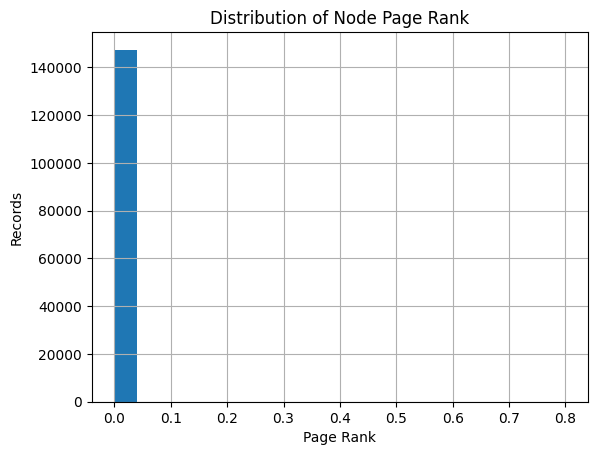

In [106]:
# let's look at the distribution of record pagerank scores
sorted_pr_df = pd.DataFrame(sorted_pr)
plt = sorted_pr_df[1].hist(bins=20, range=[0.0,0.8])
plt.set_ylabel("Records")
plt.set_xlabel("Page Rank")
plt.set_title("Distribution of Node Page Rank")

In [111]:
# extract to top 100 pageranked record ids from the sorted pagerank list
top_30_nodes_by_pagerank = list(list(zip(*sorted_pr[0:100]))[0])

recurse_query_for_pr = """
{
    q(func: eq(Record.nodeID, {LIST})) @recurse(depth: 5) {
        # predicates to return for each recurse
        id: Record.nodeID
        name: Record.name
        type: <dgraph.type>
        # predicates to loop through
        hasaddress: Record.hasAddress
        addressFor: RecordRecord.addressFor
        hasOfficer: Record.hasOfficer
        officerFor: Record.officerFor
        hasIntermediary: Record.hasIntermediary
        intermediaryFor: Record.intermediaryFor
        connectedTo: RecordRecord.connectedTo  
  }
}
"""
recurse_query_for_pr = recurse_query_for_pr.replace("{LIST}", json.dumps(top_30_nodes_by_pagerank))
res = client.txn(read_only=True).query(recurse_query_for_pr)
data = json.loads(res.json)


In [112]:
new_nodes = {}
new_edges = []
extract_dict(new_nodes, new_edges, data)

new_edges_df = pd.DataFrame(new_edges)
new_nodes_df = pd.DataFrame.from_dict(new_nodes, orient = 'index')
new_nodes_df.sample(3)


,id,name,type
14048783,14048783,LLISTER HOUSE; 35 THE PARADE; ST HELIER; JERSE...,Address
10097366,10097366,HORIZON SOFTWARE LTD.,Entity
144822,144822,Comark Investments Ltd,Entity


In [113]:
import graphistry

PASSWORD = os.getenv("GRAPHISTRY_PASSWORD")
USERNAME = os.getenv("GRAPHISTRY_USERNAME")

graphistry.register(api=3, username=USERNAME, password=PASSWORD)

g3 = graphistry.nodes(new_nodes_df, 'id').edges(new_edges_df, 'src', 'dst').bind(point_title='name')
g4 = g3.encode_point_color('type', categorical_mapping={'Entity': '#DB3B3B', 'Intermediary': '#E99233', 'Officer': '#6DB364', 'Address': '#F7D82F'}, default_mapping='gray')
g4.plot()

In [88]:
import networkx as nx

G2 = nx.from_pandas_edgelist(
    new_edges_df,
    source="src",
    target="dst",
    edge_key="type",
    create_using=nx.MultiDiGraph()
)
print(G2)
print("Network density:", "%.8f" % nx.density(G2))
try:
    print("Diameter:", nx.diameter(G2))
except nx.NetworkXError as e:
    print("Error gettting diameter", e)

MultiDiGraph with 12052 nodes and 24609 edges
Network density: 0.00016944
Error gettting diameter Found infinite path length because the digraph is not strongly connected


In [95]:
# find all paths in graph G that have four or more edges
lp_list = []
sp = dict(nx.all_pairs_shortest_path(G2))
for key, value in sp.items():
    for v in value.items():
        if len((v[1])) >= 16:
               lp_list.append(v[1])

lp_list = sorted(lp_list)
lp_list[0]

['101123',
 '142690',
 '54662',
 '124298',
 '113638',
 '138327',
 '290635',
 '170519',
 '58922',
 '173306',
 '292575',
 '168616',
 '96909',
 '157273',
 '297412',
 '148197']

### Graph Visualization

In [ ]:
import graphistry

PASSWORD = os.getenv("GRAPHISTRY_PASSWORD")
USERNAME = os.getenv("GRAPHISTRY_USERNAME")

graphistry.register(api=3, username=USERNAME, password=PASSWORD)

g = graphistry.nodes(nodes_df, 'id').edges(edges_df, 'src', 'dst').bind(point_title='name')
g2 = g.encode_point_color('type', categorical_mapping={'Entity': '#DB3B3B', 'Intermediary': '#E99233', 'Officer': '#6DB364', 'Address': '#F7D82F'}, default_mapping='gray')
g2.plot()

### Closest Path Calculation

In [114]:
closest_dql_query = """
query closest($from: string, $to: string) {
  FROM as var(func: eq(Record.nodeID, $from))
  TO as var(func: eq(Record.nodeID, $to))
    
  P as shortest(from: uid(FROM), to: uid(TO)) {
    Record.hasAddress
    Record.addressFor
    Record.hasIntermediary
    Record.intermediaryFor
    Record.hasOfficer
    Record.officerFor
    Record.sameAs
    Record.sameNameAs
    Record.similarTo
    Record.connectedTo
  }
    
  path(func: uid(P)) {
   uid
   Record.nodeID
   Record.name
   <dgraph.type>
  }
}
"""

from_node = '101123'
to_node = '148197'

#variables = {'$from': sorted_pr[0][0], '$to': sorted_pr[2][0]}
variables = {'$from': from_node, '$to': to_node}

res = client.txn(read_only=True).query(query=closest_dql_query, variables=variables)
paths = json.loads(res.json)
print(json.dumps(paths, indent=2))
    
for path in paths['path']:
    print(path)


{
  "path": [
    {
      "uid": "0x1a0283",
      "Record.nodeID": "101123",
      "Record.name": "Cathay International Beverage Limited",
      "dgraph.type": [
        "Officer",
        "Record"
      ]
    },
    {
      "uid": "0x16e68e",
      "Record.nodeID": "142690",
      "Record.name": "C & C BEVERAGES LIMITED",
      "dgraph.type": [
        "Entity",
        "Record"
      ]
    },
    {
      "uid": "0x16e366",
      "Record.nodeID": "54662",
      "Record.name": "Portcullis TrustNet (BVI) Limited",
      "dgraph.type": [
        "Intermediary",
        "Record"
      ]
    },
    {
      "uid": "0x49c4b",
      "Record.nodeID": "160833",
      "Record.name": "V-FLO GROUP OF COMPANIES LIMITED",
      "dgraph.type": [
        "Entity",
        "Record"
      ]
    },
    {
      "uid": "0x2191d6",
      "Record.nodeID": "236724",
      "Record.name": "Portcullis TrustNet Chambers P.O. Box 3444 Road Town, Tortola British Virgin Islands (w.e.f 9 December 2005)",
      "dgra

In [115]:
import ipycytoscape

graph_data = {"nodes": [], "edges": []}
# find the nodes
for idx, path in enumerate(paths['path']):
    entity_type = path['dgraph.type'][0]
    #graph_data['nodes'].append({"data": {"id": path['Record.nodeID'], "label": path['Record.name'], "tooltip": "<div style='background-color:white'>foo</div>"}, "classes": entity_type})
    graph_data['nodes'].append({"data": {"id": path['Record.nodeID'], "label": path['Record.name'], "type": entity_type}, "classes": entity_type})
    if idx < len(paths['path'])-1:
        graph_data['edges'].append({"data": {"uid": path['uid'], "source": path['Record.nodeID'], "target": paths['path'][idx+1]['Record.nodeID']}})

def find_edge_type(d: dict):
    uid = d['uid']
    for key, entry in d.items():
        if isinstance(entry, dict):
            for edge in graph_data['edges']:
                if edge['data']['uid'] == uid:
                    edge['data']['label'] = key[7:]
            find_edge_type(entry)
 
        
# recursively find the edge types
find_edge_type(paths['_path_'][0])
                           
print(graph_data)

{'nodes': [{'data': {'id': '101123', 'label': 'Cathay International Beverage Limited', 'type': 'Officer'}, 'classes': 'Officer'}, {'data': {'id': '142690', 'label': 'C & C BEVERAGES LIMITED', 'type': 'Entity'}, 'classes': 'Entity'}, {'data': {'id': '54662', 'label': 'Portcullis TrustNet (BVI) Limited', 'type': 'Intermediary'}, 'classes': 'Intermediary'}, {'data': {'id': '160833', 'label': 'V-FLO GROUP OF COMPANIES LIMITED', 'type': 'Entity'}, 'classes': 'Entity'}, {'data': {'id': '236724', 'label': 'Portcullis TrustNet Chambers P.O. Box 3444 Road Town, Tortola British Virgin Islands (w.e.f 9 December 2005)', 'type': 'Address'}, 'classes': 'Address'}, {'data': {'id': '134151', 'label': 'Aswibek Co., Ltd.', 'type': 'Entity'}, 'classes': 'Entity'}, {'data': {'id': '237076', 'label': 'David Chong & Co. Office B1, 7/F. Loyong Court 212-220 Lockhart Road Wanchai Hong Kong CAYMAN ISLANDS', 'type': 'Address'}, 'classes': 'Address'}, {'data': {'id': '173870', 'label': 'SHIN-TOW OVERSEAS HOLDING

In [127]:
from pprint import pformat

cyto_styles = [
    {'selector': 'node[type = "Address"]', 'style': {
        'font-family': 'helvetica',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'blue'}},
    {'selector': 'node[type = "Entity"]', 'style': {
        'font-family': 'helvetica',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'green'}},
    {'selector': 'node[type = "Intermediary"]', 'style': {
        'font-family': 'helvetica',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'yellow'}},
    {'selector': 'node[type = "Officer"]', 'style': {
        'font-family': 'helvetica',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'purple'}},
    {'selector': 'node[type = "Other"]', 'style': {
        'font-family': 'helvetica',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': '#999999'}},
    {'selector': 'node.flagged','style': {
        'border-color': 'red',
        'border-width': '4px'}},    
    {'selector': 'node:parent',
        'css': {
            'background-opacity': 0.333
        }
    },
    {'selector': 'edge', 'style': {
        'width': 3,
        'font-size': '9px',
        'line-color': '#9dbaea',
        'target-arrow-shape': 'triangle',
        'target-arrow-color': '#9dbaea',
        'curve-style': 'bezier',
        'label': 'data(label)'
    }
}]

cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(graph_data)
cytoscapeobj.set_layout(name='cola', nodeSpacing=20, edgeLengthVal=10)
cytoscapeobj.set_style(cyto_styles)
#display
cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 20, 'edgeLengthVal': 10}, cytoscape_style=[{'…

### Full text query

In [ ]:
%%time

ft_query = """
query ($filter: EntityFilter) {
  queryEntity(filter: $filter) {
    id: nodeID
    type: __typename
    name
  }
}
"""
variables = {
    "filter": {
        "name": {
            "anyoftext": "live"
        }
    }
}
data = gql_client.execute(query=ft_query, variables=variables)
for res in data['data']['queryEntity']:
    print(res['name'])
        

### Search via Geo-coordinates

In [ ]:
geo_query = """
query ($filter: AddressFilter) {
  queryAddress(filter: $filter) {
    nodeID
    name
    location {
      latitude
      longitude
    }
    addressFor {
      nodeID
      __typename
      name
    }
  }
}"""
variables = {
  "filter": {
    "has": "location"
  }
}

data = gql_client.execute(query=geo_query, variables=variables)

addresses_df = pd.json_normalize(data['data']['queryAddress'])

def extract_names(l):
    name = ''
    for entry in l:
        name += entry['__typename'] + ": " + entry['name'] + ", "
    return name[0:len(name)-2]

addresses_df = addresses_df.rename(columns={"location.latitude": "lat", "location.longitude": "lon"})
addresses_df['addressFor'] = addresses_df['addressFor'].apply(lambda val: extract_names(val))
addresses_df.sample(5)


In [ ]:
import bokeh.io
from bokeh.plotting import gmap
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.io import output_file, show
from bokeh.models import HoverTool
from bokeh.resources import INLINE
bokeh.io.output_notebook(INLINE)

lat = 39.116386
lng = -99.299591
google_map_options = GMapOptions(lat = lat, lng = lng, map_type = "hybrid", zoom = 4)

hover = HoverTool(
        tooltips = [
            ('address', '@name'),
            ('addressFor', '@addressFor'), 
        ]
    )

google_maps_key = os.getenv("GOOGLE_MAPS_KEY")
google_map = gmap(google_maps_key, google_map_options, title="US Addresses", 
                  tools=[hover, 'reset', 'wheel_zoom', 'pan'], width=1200, height=640)
source = ColumnDataSource(addresses_df)
google_map.square(x="lon", y="lat", size=8, fill_color="red", fill_alpha=0.7, source=source)
show(google_map)


In [ ]:
%%time

# Query for addresses near point

# syracuse ny
lat = 43.088947
lng = -76.154480
# los angeles
lat = 34.098907
lng = -118.327759


miles = 50
meters = miles * 1609
variables = {
  "filter": {
    "location": {
      "near": {
        "coordinate": {
          "latitude": lat,
          "longitude": lng
        },
        "distance": meters
      }
    }
  }
}

data = gql_client.execute(query=geo_query, variables=variables)

addresses_df = pd.json_normalize(data['data']['queryAddress'])

addresses_df = addresses_df.rename(columns={"location.latitude": "lat", "location.longitude": "lon"})
addresses_df['addressFor'] = addresses_df['addressFor'].apply(lambda val: extract_names(val))

google_map_options = GMapOptions(lat = lat, lng = lng, map_type = "hybrid", zoom = 10)

hover = HoverTool(
        tooltips = [
            ('address', '@name'),
            ('addressFor', '@addressFor'), 
        ]
    )

google_map = gmap(google_maps_key, google_map_options, title="Addresses near Syracuse NY", 
                  tools=[hover, 'reset', 'wheel_zoom', 'pan'], width=1200, height=640)
source = ColumnDataSource(addresses_df)
google_map.square(x="lon", y="lat", size=12, fill_color="red", fill_alpha=0.7, source=source)
show(google_map)

### Mutating Dgraph

In [ ]:
def is_flagged(node):
    return 'flagged' in node and len(node['flagged']) > 0
                                 
def convert_to_cyto_objs(nodes, edges):
    graph_data = {"nodes": [], "edges": []}
    # find the nodes
    for node in nodes.items():
        node = node[1]
        entity_type = node['type']
        classes = ''
        if is_flagged(node):
            classes = 'flagged'
        graph_data['nodes'].append({"data": {"id": node['id'], "label": node['name'], "type": entity_type, "flagged": is_flagged(node)}, "classes": classes})
    for edge in edges:
        graph_data['edges'].append({"data": {"source": edge['src'], "target": edge['dst'], "label": edge['type']}})
    return graph_data


In [ ]:
%%time

recurse_query = """
{
	q(func: eq(Record.nodeID, "236724")) @recurse(depth: 5) {
        # predicates to return for each recurse
        id: Record.nodeID
        name: Record.name
        type: <dgraph.type>
        
        # predicates to loop through
        addressFor: Record.addressFor(first: 30)
        hasOfficer: Record.hasOfficer
        hasIntermediary: Record.hasIntermediary
        connectedTo: RecordRecord.connectedTo  
    }
}
"""

nodes = {}
edges = []

txn = client.txn(read_only=True)
try:
    res = txn.query(query=recurse_query)
    results = json.loads(res.json)
    extract_dict(nodes, edges, results)
finally:
    txn.discard()

recurse_viz = ipycytoscape.CytoscapeWidget()
recurse_viz.set_layout(name='cola', nodeSpacing=20, edgeLengthVal=10)
recurse_viz.set_style(cyto_styles)
cyto_obj = convert_to_cyto_objs(nodes, edges)
recurse_viz.graph.add_graph_from_json(cyto_obj)
#display
recurse_viz

In [ ]:
# Update the GraphQL schema with 'flagged' predicate
!curl --data-binary '@./schema-flagged.graphql' http://localhost:8080/admin/schema

In [ ]:
email = "matthew.mcneely@gmail.com"

flagged_mutation = """
mutation ($input: UpdateRecordInput!) {
  updateRecord(input: $input) {
    numUids
    record {
      flagged
    }
  }
}
"""

def record_click(node):
    nodeID = node['data']['id']
    variables = {
      "input": {
        "filter": {
          "nodeID": {
            "eq": nodeID
          }
        },
        "set": {
          "flagged": [email]
        }
      }
    }
    data = gql_client.execute(query=flagged_mutation, variables=variables)
    print(data)

recurse_viz.on('node', 'click', record_click)


In [ ]:
recurse_query = """
{
	q(func: eq(Record.nodeID, "236724")) @recurse(depth: 5) {
        # predicates to return for each recurse
        id: Record.nodeID
        name: Record.name
        type: <dgraph.type>
        flagged: Record.flagged
        
        # predicates to loop through
        addressFor: Record.addressFor(first: 30)
        hasOfficer: Record.hasOfficer
        hasIntermediary: Record.hasIntermediary
        connectedTo: RecordRecord.connectedTo  
    }
}
"""

nodes = {}
edges = []

txn = client.txn(read_only=True)
try:
    res = txn.query(query=recurse_query)
    results = json.loads(res.json)
    extract_dict(nodes, edges, results)
finally:
    txn.discard()

recurse_viz = ipycytoscape.CytoscapeWidget()
recurse_viz.set_layout(name='cola', nodeSpacing=20, edgeLengthVal=10)
recurse_viz.set_style(cyto_styles)
cyto_obj = convert_to_cyto_objs(nodes, edges)
recurse_viz.graph.add_graph_from_json(cyto_obj)
#display
recurse_viz